In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pyatomdb
from astropy.io import fits

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

my_colours = ['#4DAF4A', '#377EB8', '#984EA3', '#E41A1C', '#FF7F00']

In [2]:
# Initialize ROSAT spectrum session
rosat = pyatomdb.spectrum.CIESession()

# Set the metallicity to 0.3 of the solar value
Zmetal = 0.3
Zs = np.ones(31)
Zs[3:] = Zmetal
rosat.set_abund(np.arange(31, dtype=int), Zs)

# Read response matrix (RMF) and auxiliary response file (ARF)
rmf = fits.open("data/pspcc_gain1_256.rmf")
arf = fits.open("data/pspcc_gain1_256.arf")

### Generate the raw spectra

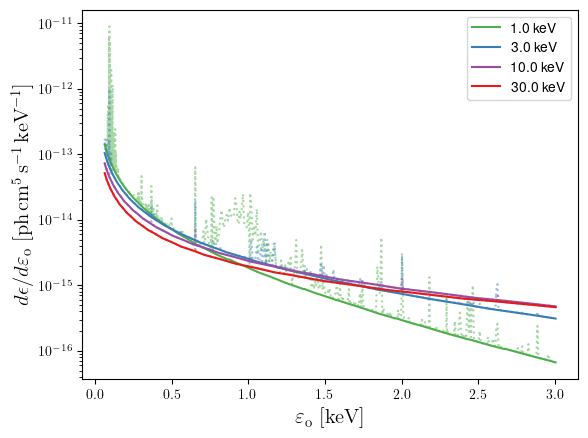

In [3]:
# Extract the energy bins
specbins_in = rmf["SPECRESP MATRIX"].data["ENERG_LO"]
specbins_in = np.append(specbins_in,
                        rmf["SPECRESP MATRIX"].data["ENERG_HI"][-1])

rosat.set_response(specbins_in, raw=True)

emean_in = 0.5 * (specbins_in[:-1] + specbins_in[1:])

# Plot the ROSAT spectra for different temperatures
plt.figure()
for kT, color in zip([1.0, 3.0, 10.0, 30.0], my_colours):
    spec_raw = rosat.return_spectrum(kT, 0.0) / np.diff(specbins_in)
    spec_con_raw = rosat.return_spectrum(kT, 0.0,
                                     dolines=False,
                                     dopseudo=False) / np.diff(specbins_in)
    plt.plot(emean_in, spec_con_raw, color=color, label=f"{kT} keV")
    plt.plot(emean_in, spec_raw, color=color, linestyle=":", alpha=0.5)
    
plt.yscale("log")
plt.legend()

plt.ylabel(r"$d\epsilon/d\varepsilon_{\rm o}\,\,"
          +r"[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}\,{\rm keV}^{-1}]$",
          fontsize=15);
plt.xlabel(r"$\varepsilon_{\rm o}\,\,[{\rm keV}]$", fontsize=15);

## Generate the spectra with ROSAT response matrices

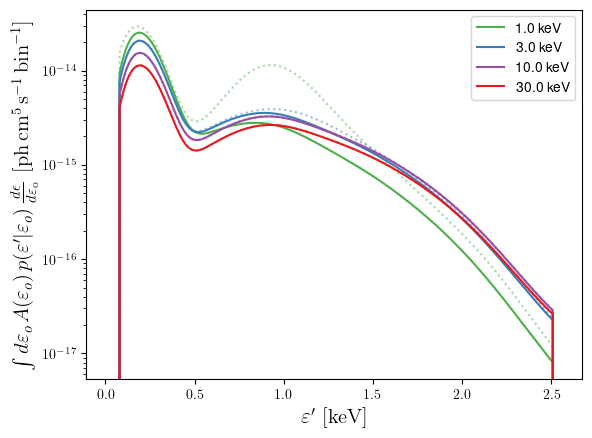

In [4]:
# Set the response using RMF and ARF
rosat.set_response(rmf, arf)

# Extract energy bins
specbins_out = rosat.ebins_out

emean_out = 0.5 * (specbins_out[:-1] + specbins_out[1:])

# Plot the ROSAT spectra for different temperatures
plt.figure()
for kT, color in zip([1.0, 3.0, 10.0, 30.0], my_colours):
    spec = rosat.return_spectrum(kT, 0.0)
    spec_con = rosat.return_spectrum(kT, 0.0,
                                     dolines=False,
                                     dopseudo=False)
    plt.plot(emean_out, spec_con, color=color, label=f"{kT} keV")
    plt.plot(emean_out, spec, color=color, linestyle=":", alpha=0.5)

plt.yscale("log")
plt.legend()

plt.ylabel(r"$\int d\varepsilon_o\,A(\varepsilon_o)\,"
           +r"p(\varepsilon'|\varepsilon_o)\,"
           +r"\frac{d\epsilon}{d\varepsilon_{\rm o}}\,\,"
           +r"[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}\,{\rm bin}^{-1}]$",
           fontsize=15);
plt.xlabel(r"$\varepsilon'\,\,[{\rm keV}]$", fontsize=15);

# Plot integrated spectra for different redshifts and temperatures

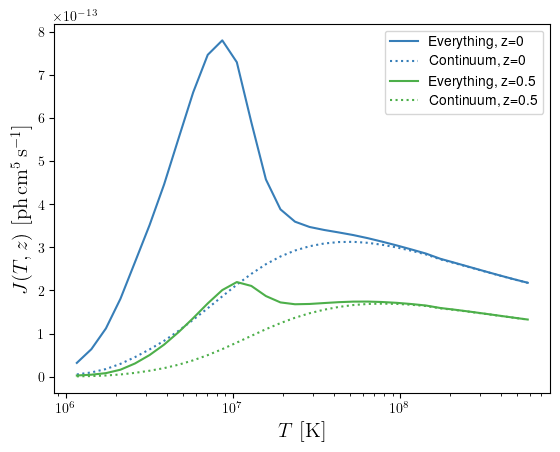

In [5]:
plt.figure()

kTs = np.geomspace(0.1, 50.0, 32)
# Transforms keV to Kelvin
kT2T = 11604518.1

z = 0.0
Js_cont = np.array(
    [rosat.return_integrated_spectrum(kT, 0.5, 2.0, z,
                                      dolines=False,
                                      dopseudo=False)
        for kT in kTs])
Js_all = np.array(
    [rosat.return_integrated_spectrum(kT, 0.5, 2.0, z)
        for kT in kTs])
plt.plot(kTs * kT2T, Js_all,
         color="#377EB8",
         label="Everything, z=0")
plt.plot(kTs * kT2T, Js_cont,
         color="#377EB8",
         linestyle= ":",
         label="Continuum, z=0")

z = 0.5
Js_cont = np.array(
    [rosat.return_integrated_spectrum(kT, 0.5, 2.0, z,
                                      dolines=False,
                                      dopseudo=False)
        for kT in kTs])
Js_all = np.array(
    [rosat.return_integrated_spectrum(kT, 0.5, 2.0, z)
        for kT in kTs])
plt.plot(kTs * kT2T, Js_all,
         color="#4DAF4A",
         label="Everything, z=0.5")
plt.plot(kTs * kT2T, Js_cont,
         color="#4DAF4A",
         linestyle= ":",
         label="Continuum, z=0.5")

plt.xscale("log")
# plt.yscale('log')
plt.legend()

plt.ylabel(r"$J(T,z)\,\,"
           +r"[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}]$",
           fontsize=15);
plt.xlabel(r"$T\,\,[{\rm K}]$", fontsize=15);

### Faster with pre-interpolation

In [6]:
kTmin = 0.1
kTmax = 50.0
nkT = 32
zmax = 1.0
nz = 4
emin = 0.5
emax = 2.0
ip_cont = rosat.return_integrated_spectrum_interp(kTmin, kTmax,
                                                  nkT, zmax, nz,
                                                  emin, emax,
                                                  dolines=False,
                                                  dopseudo=False)
ip_all = rosat.return_integrated_spectrum_interp(kTmin, kTmax,
                                                  nkT, zmax, nz,
                                                  emin, emax)

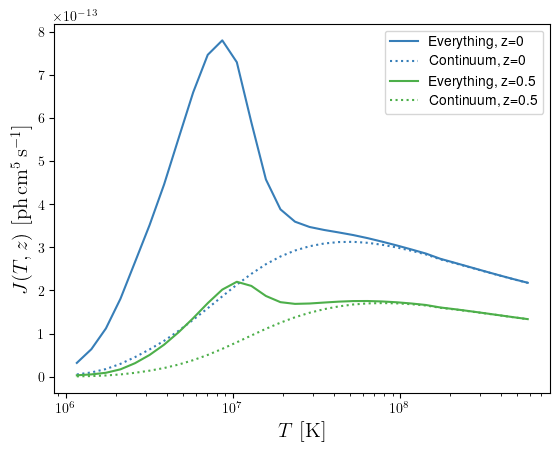

In [7]:
plt.figure()

kTs = np.geomspace(0.1, 50.0, 32)
# Transforms keV to Kelvin
kT2T = 11604518.1

z = 0.0
ev = np.array([[lkt, z] for lkt in np.log(kTs)])
Js_cont_b = np.exp(ip_cont(ev))
Js_all_b = np.exp(ip_all(ev))
plt.plot(kTs * kT2T, Js_all_b,
         color="#377EB8",
         label="Everything, z=0")
plt.plot(kTs * kT2T, Js_cont_b,
         color="#377EB8",
         linestyle= ":",
         label="Continuum, z=0")

z = 0.5
ev = np.array([[lkt, z] for lkt in np.log(kTs)])
Js_cont_b = np.exp(ip_cont(ev))
Js_all_b = np.exp(ip_all(ev))
plt.plot(kTs * kT2T, Js_all_b,
         color="#4DAF4A",
         label="Everything, z=0.5")
plt.plot(kTs * kT2T, Js_cont_b,
         color="#4DAF4A",
         linestyle= ":",
         label="Continuum, z=0.5")

plt.xscale("log")
# plt.yscale('log')
plt.legend()

plt.ylabel(r"$J(T,z)\,\,"
           +r"[{\rm ph}\,{\rm cm}^5\,{\rm s}^{-1}]$",
           fontsize=15);
plt.xlabel(r"$T\,\,[{\rm K}]$",
           fontsize=15);

## Compare spectra generated with [RSP] or [RMF and ARF]

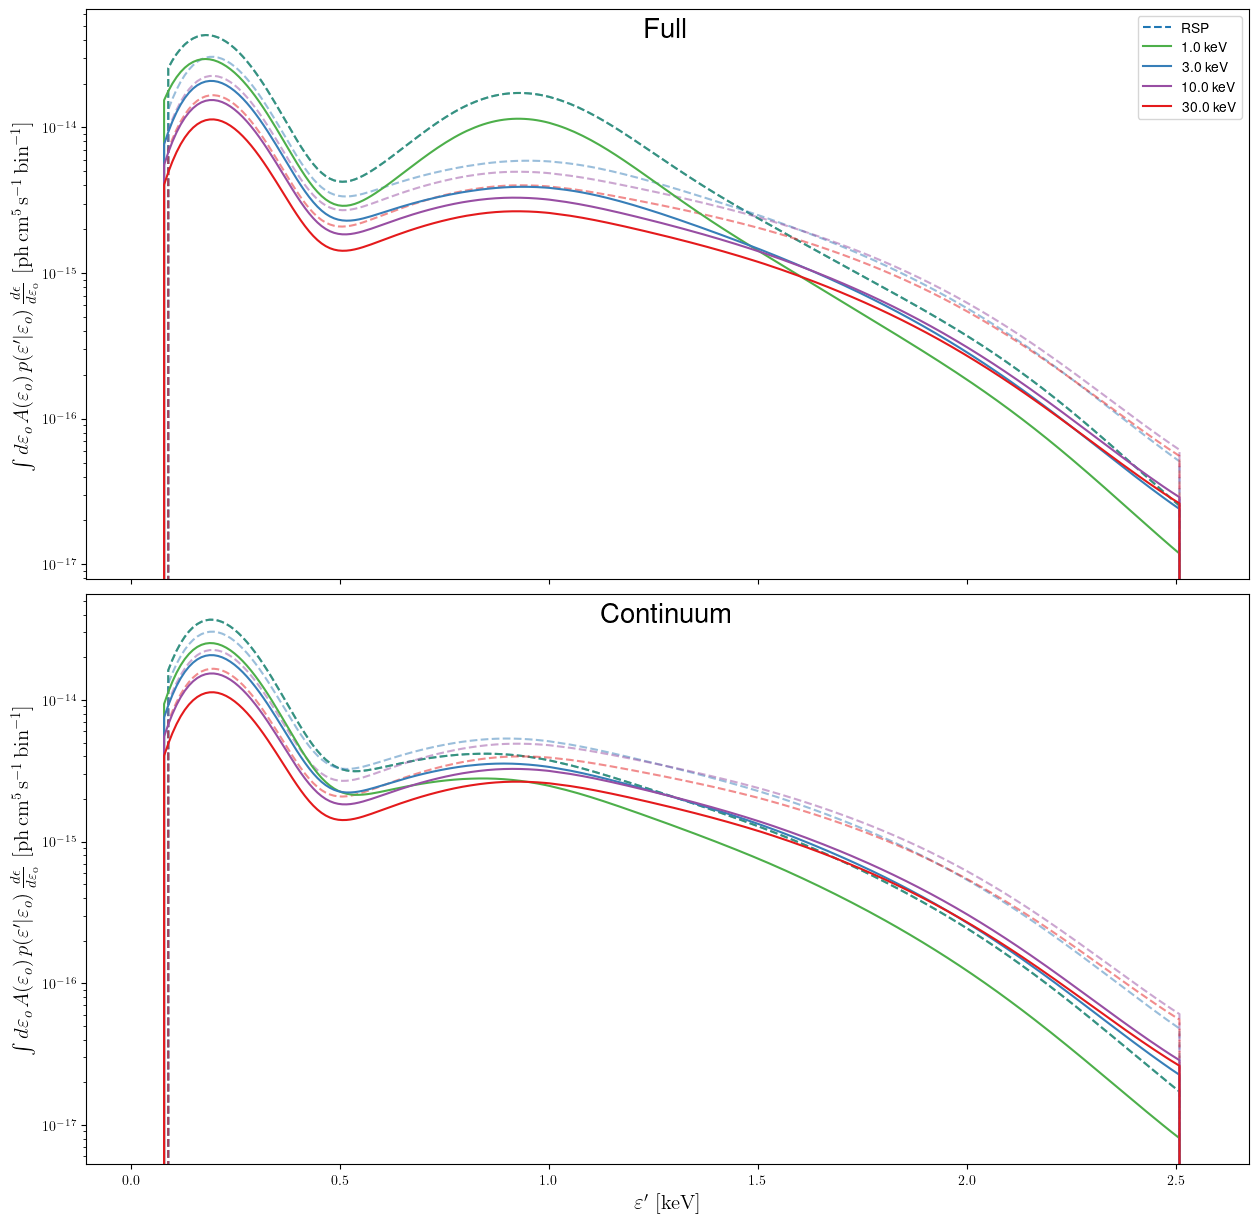

In [8]:
rsp = fits.open("data/pspcc_gain1_256.rsp")

rsp_h = rsp[1].data
chans_h = rsp[2].data

# Energy bins
n_energ = len(rsp_h['ENERG_HI'])
energ_bins = np.zeros(n_energ+1)
energ_bins[:-1] = rsp_h["ENERG_LO"]
energ_bins[-1] = rsp_h["ENERG_HI"][-1]

# Channels
n_chan = len(chans_h['E_MAX'])
energ_chans = np.zeros(n_chan+1)
energ_chans[:-1] = chans_h['E_MIN']
energ_chans[-1] = chans_h['E_MAX'][-1]

emean_chans = 0.5*(energ_chans[:-1]+energ_chans[1:])

m_x_A = np.zeros([n_energ, n_chan])

for i in range(n_energ):
    ngrp = rsp_h['N_GRP'][i]
    if ngrp == 0:
        continue
   
    i_first = rsp_h['F_CHAN'][i]-1

    n_ch = rsp_h['N_CHAN'][i]
    row = rsp_h['MATRIX'][i]
    m_x_A[i, i_first:i_first+n_ch] = row[:n_ch]


fig, (ax_full, ax_cont) = plt.subplots(2, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.025)

# Spectra with RSP
rosat.set_response(energ_bins, raw=True)

ax_cont.plot(emean_chans, np.dot(rosat.return_spectrum(1.0,
                                                       dolines=False,
                                                       dopseudo=False), 
                                 m_x_A), "--")
ax_full.plot(emean_chans, np.dot(rosat.return_spectrum(1.0),
                                 m_x_A), "--", label="RSP")

for kT, c in zip([1.0, 3.0, 10.0, 30.0], my_colours):
    spec_rsp = np.dot(rosat.return_spectrum(kT), m_x_A)
    spec_con_rsp = np.dot(rosat.return_spectrum(kT,
                                     dolines=False,
                                     dopseudo=False), m_x_A)
    ax_cont.plot(emean_chans, spec_con_rsp, "--", color=c, alpha=0.5)
    ax_full.plot(emean_chans, spec_rsp, "--", color=c, alpha=0.5)

# Spectra with RMF and ARF
rosat.set_response(rmf, arf)

for kT, c in zip([1.0, 3.0, 10.0, 30.0], my_colours):
    spec = rosat.return_spectrum(kT, 0.0)
    spec_con = rosat.return_spectrum(kT, 0.0,
                                     dolines=False,
                                     dopseudo=False)
    ax_cont.plot(emean_out, spec_con, color=c)
    ax_full.plot(emean_out, spec, color=c, label=f"{kT} keV")


ax_cont.set_yscale("log")
ax_cont.set_title("Continuum", fontsize=20, y=1.0, pad=-20)

ax_full.set_yscale("log")
ax_full.set_title("Full", fontsize=20, y=1.0, pad=-20)
ax_full.tick_params(labelbottom=False)
ax_full.legend()

ax_full.set_ylabel(r"$\int d\varepsilon_o\,A(\varepsilon_o)\,"
                   +r"p(\varepsilon'|\varepsilon_o)\,"
                   +r"\frac{d\epsilon}{d\varepsilon_{\rm o}}\,\,"
                   +r"[{\rm ph}\,{\rm cm}^5\,"
                   +r"{\rm s}^{-1}\,{\rm bin}^{-1}]$",
                   fontsize=15);
ax_cont.set_ylabel(r"$\int d\varepsilon_o\,A(\varepsilon_o)\,"
                   +r"p(\varepsilon'|\varepsilon_o)\,"
                   +r"\frac{d\epsilon}{d\varepsilon_{\rm o}}\,\,"
                   +r"[{\rm ph}\,{\rm cm}^5\,"
                   +r"{\rm s}^{-1}\,{\rm bin}^{-1}]$",
                   fontsize=15);
ax_cont.set_xlabel(r"$\varepsilon'\,\,[{\rm keV}]$", fontsize=15);